In [1]:
# Stiff Robertson's problem from chemical kinetics as in
# https://archimede.uniba.it/~testset/report/rober.pdf
import numpy as np
import matplotlib.pyplot as plt
import time

a = 0.04
b = 1.0e4
c = 3.0e7

# timestep, Tmax, tolearnce for Newton's solver
h = 1.0e-3
Tmax = 1.0e2 # up to 4.0e10
Nsteps = int(np.ceil(Tmax/h))
tol = 1.0e-14
itermax = 20

# initial condition
y0 = np.array([1.0,0.0,0.0])

# the right-hand side
def func(y): 
    dy = np.zeros(3)
    byz = b*y[1]*y[2]
    cy2 = c*y[1]*y[1]
    ax = a*y[0]
    dy[0] = -ax + byz
    dy[1] = ax - byz - cy2
    dy[2] = cy2
    return dy

# the Jacobian matrix for the right-hand side
def Jac(y):
    by = b*y[1]
    bz = b*y[2]
    c2y = 2*c*y[1]
    Jac = np.zeros((3,3))
    Jac[0,0] = -a
    Jac[0,1] = bz
    Jac[0,2] = by
    Jac[1,0] = a
    Jac[1,1] = -bz-c2y
    Jac[1,2] = -by
    Jac[2,1] = c2y
    return Jac


In [2]:
# DIRK2

def NewtonIterDIRK2(y,h,k,gamma):
    aux = y + h*gamma*k
    F = k - func(aux)
    DF = np.identity(3) - h*gamma*Jac(aux)
    return k - np.linalg.solve(DF,F)

def DIRK2step(y,h):
    gamma = 1.0 - 1.0/np.sqrt(2)
    k1 = func(y)
    for j in range(itermax):
        k1 = NewtonIterDIRK2(y,h,k1,gamma)
        if np.linalg.norm(k1 - func(y + h*gamma*k1)) < tol:
            break
    # print( np.linalg.norm(k1 - func(y + h*gamma*k1)))
    # print(j)
    k2 = k1
    y = y + h*(1-gamma)*k1
    for j in range(itermax):
        k2 = NewtonIterDIRK2(y,h,k2,gamma)
        aux = y + h*gamma*k2
        if np.linalg.norm(k2 - func(aux)) < tol:
            break
    # print( np.linalg.norm(k2 - func(aux)))
    # print(j)
    return aux


In [3]:
# solve Robertson's problem

sol = np.zeros((Nsteps+1,3))
t = np.arange(0,(Nsteps+1)*h,h)
sol[0,:] = y0

start_time = time.time()

method_name = "DIRK2"
for j in range(Nsteps): # DIRK2
    sol[j+1,:] = DIRK2step(sol[j,:],h)

end_time = time.time()
t_cpu = end_time - start_time

print(f'method = {method_name:5}, CPUtime = {t_cpu:.6e}')
  

method = DIRK2, CPUtime = 2.133622e+00


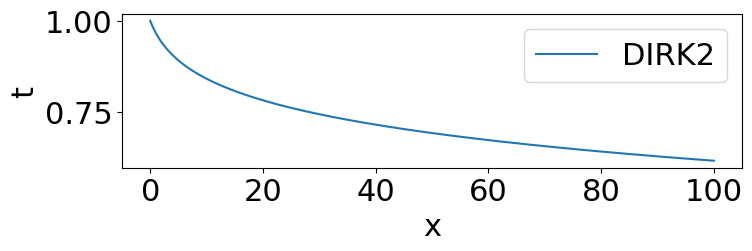

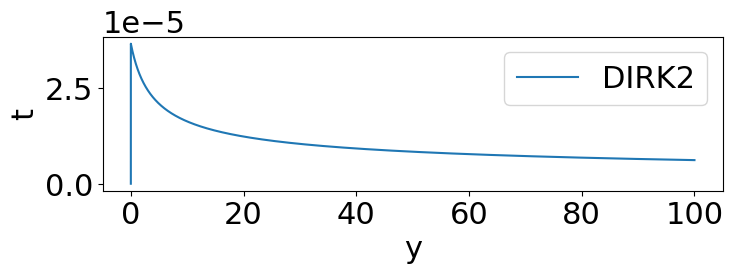

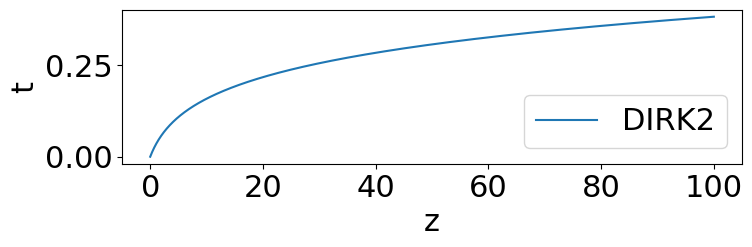

In [4]:
# plot the solution
plt.rcParams.update({'font.size': 22})
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,0],label = "DIRK2")
plt.xlabel("x")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,1],label = "DIRK2")
plt.xlabel("y")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
fig, ax = plt.subplots(figsize = (8,2))
plt.plot(t,sol[:,2],label = "DIRK2")
plt.xlabel("z")
plt.ylabel("t")
plt.legend()
#plt.xscale("log")
